In [62]:
import numpy as np
import pandas as pd
import os
import sklearn
import time

import sklearn
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

# Custom functions 
def print_gridsearch_results(grid_searcher, unique_params):
    # For a given gridsearcher and the relevant params used in grid_search, print the results of the runs
    # Get the data as a pandas DF
    gsearch_results_df = pd.DataFrame(grid_searcher.cv_results_).copy()
    print("Dataframe has shape: %s" % (str(gsearch_results_df.shape)))
    n_trials_grid_search = gsearch_results_df.shape[0]
    print("Number of trials used in grid search: ", n_trials_grid_search)

    # Rearrange row order so it is easy to skim
    gsearch_results_df.sort_values('rank_test_score', inplace=True)
    # Transform param-text to match up with cv_results_ representation
    param_keys = [f"param_{key}" for key in unique_params]
    return(gsearch_results_df[param_keys + ['mean_train_score', 'mean_test_score', 'mean_fit_time', 'rank_test_score']])


def plot_cv_folds(cv_results, param_name, param_label, folds, log10=False, log2=False):
    _, ax = plt.subplots(1, 1)

    # Get averages
    mean_test_score = cv_results['mean_test_score']
    mean_train_score = cv_results['mean_train_score']

    # Get x_values
    param_values = cv_results[f'param_{param_name}']
    x_values = param_values.data.astype(np.float64)
    if (log10):
        x_values = np.log10(x_values)
    elif (log2):
        x_values = np.log2(x_values)

    ax.plot(x_values, mean_test_score, 'bs', label=f'average test')
    ax.plot(x_values, mean_train_score, 'rs', label=f'average train')

    # Get overall mean_train_score
    for fold in range(folds):
        fold_scores = cv_results[f'split{fold}_test_score']
        ax.plot(x_values, fold_scores, 's', label=f'{fold}-validation set')

    ax.set_title(f"{param_label} Grid Search Scores", fontsize=20, fontweight='bold')
    ax.set_xlabel(param_label, fontsize=16)
    ax.set_ylabel('Balanced Accuracy', fontsize=16)
    ax.legend(loc="best", fontsize=15, bbox_to_anchor=(1, 1))

RANDOM_STATE = 123

In [45]:
# Plotting utils
import matplotlib
import matplotlib.pyplot as plt

%matplotlib inline
plt.style.use('seaborn') # pretty matplotlib plots

import seaborn as sns
sns.set('notebook', font_scale=1.25, style='whitegrid')

# Setup: Importing the Text


In [46]:
data_dir = '../data_reviews'
x_train_df = pd.read_csv(os.path.join(data_dir, 'x_train.csv'))
y_train_df = pd.read_csv(os.path.join(data_dir, 'y_train.csv'))

print("Shape of data\n---------------")
print(f"x_train_df shape: {x_train_df.shape} ")
print(f"y_train_df shape: {y_train_df.shape} ")

# Get the text as a list of strings
x_train_text = x_train_df['text'].values
y_train = y_train_df['is_positive_sentiment'].values

Shape of data
---------------
x_train_df shape: (2400, 2) 
y_train_df shape: (2400, 1) 


## Basic comparison of two vectorizers - one with counts and one using tfidf

In [47]:
count_vectorizer = CountVectorizer(stop_words='english')
count_vectorizer.fit_transform(x_train_text)
x_train_text_count = count_vectorizer.transform(x_train_text).toarray()


In [48]:
len(count_vectorizer.vocabulary_)

4255

In [49]:
tf_vectorizer = TfidfVectorizer(stop_words='english')
tf_vectorizer.fit_transform(x_train_text)
x_train_text_tf = tf_vectorizer.transform(x_train_text).toarray()

In [50]:
len(tf_vectorizer.vocabulary_)

4255

## Train two Random Forests to compare performance

This manual approach to training models is no longer neceesary, as the pipeline enables a much speedier and more effective way of performing this comparison while also tuning hyperparameters.


In [102]:
folds = 5

### Using pipeline to try many tf-idf hyperparameters

In [103]:
tfidf_pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(stop_words='english')),
#     ('clf', RandomForestClassifier(random_state=RANDOM_STATE)),
    ('clf', sklearn.linear_model.LogisticRegression(penalty='l1', solver='saga', random_state=RANDOM_STATE, C=10.0, max_iter=20))
 ])
tfidf_parameters = {
    'tfidf__min_df': np.arange(1,10),
    'tfidf__max_df': (0.01, 0.05, 1.0),
    'tfidf__ngram_range': [(1, 1), (1, 2)],
}

tfidf_grid_searcher = GridSearchCV(
    tfidf_pipeline, 
    tfidf_parameters, 
    cv=folds, 
    n_jobs=3, 
    verbose=3,
    scoring='balanced_accuracy',
    return_train_score=True
)
tfidf_grid_searcher.fit(x_train_text, y_train)

Fitting 5 folds for each of 54 candidates, totalling 270 fits


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  26 tasks      | elapsed:    5.1s
[Parallel(n_jobs=3)]: Done 154 tasks      | elapsed:   13.9s
[Parallel(n_jobs=3)]: Done 270 out of 270 | elapsed:   21.1s finished
/Users/dylanphelan/opt/miniconda3/envs/comp135_2020f_env/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('tfidf',
                                        TfidfVectorizer(stop_words='english')),
                                       ('clf',
                                        LogisticRegression(C=10.0, max_iter=20,
                                                           penalty='l1',
                                                           random_state=123,
                                                           solver='saga'))]),
             n_jobs=3,
             param_grid={'tfidf__max_df': (0.01, 0.05, 1.0),
                         'tfidf__min_df': array([1, 2, 3, 4, 5, 6, 7, 8, 9]),
                         'tfidf__ngram_range': [(1, 1), (1, 2)]},
             return_train_score=True, scoring='balanced_accuracy', verbose=3)

In [104]:
print_gridsearch_results(tfidf_grid_searcher, list(tfidf_parameters.keys()))

Dataframe has shape: (54, 23)
Number of trials used in grid search:  54


,param_tfidf__min_df,param_tfidf__max_df,param_tfidf__ngram_range,mean_train_score,mean_test_score,mean_fit_time,rank_test_score
37,1,1,"(1, 2)",0.995104,0.782083,0.627658,1
36,1,1,"(1, 1)",0.987813,0.779583,0.359295,2
38,2,1,"(1, 1)",0.969792,0.772083,0.227093,3
39,2,1,"(1, 2)",0.979271,0.771667,0.286120,4
19,1,0.05,"(1, 2)",0.996146,0.752083,0.722176,5
44,5,1,"(1, 1)",0.877083,0.744583,0.103962,6
40,3,1,"(1, 1)",0.934896,0.744167,0.166789,7
45,5,1,"(1, 2)",0.877917,0.743750,0.124184,8
41,3,1,"(1, 2)",0.941771,0.742917,0.195874,9
42,4,1,"(1, 1)",0.905937,0.742500,0.128549,10


In [105]:
print("Best parameters set:")
print(tfidf_grid_searcher.best_estimator_[0])
print(tfidf_grid_searcher.best_params_)
cv_results = tfidf_grid_searcher.cv_results_
cv_results

Best parameters set:
TfidfVectorizer(ngram_range=(1, 2), stop_words='english')
{'tfidf__max_df': 1.0, 'tfidf__min_df': 1, 'tfidf__ngram_range': (1, 2)}


{'mean_fit_time': array([0.41705341, 0.78153944, 0.24127297, 0.30119338, 0.16214309,
        0.19533405, 0.11548848, 0.14339452, 0.09460835, 0.14878502,
        0.09748807, 0.09908237, 0.0686636 , 0.08638668, 0.05812721,
        0.07403407, 0.05115304, 0.07173514, 0.42727718, 0.72217598,
        0.24328909, 0.27989664, 0.17683983, 0.20724039, 0.13257799,
        0.16240916, 0.10305166, 0.1190599 , 0.09272642, 0.12536974,
        0.0868124 , 0.0930006 , 0.06507387, 0.08627691, 0.06250191,
        0.07854805, 0.35929527, 0.62765765, 0.22709298, 0.28611979,
        0.16678948, 0.19587398, 0.12854929, 0.14964881, 0.10396204,
        0.12418361, 0.08508134, 0.10201492, 0.07200518, 0.09154763,
        0.06895199, 0.08568902, 0.06033444, 0.07893658]),
 'std_fit_time': array([0.01531028, 0.02158322, 0.01753492, 0.02238398, 0.00767156,
        0.0084685 , 0.00841808, 0.00646738, 0.00694429, 0.00906505,
        0.01464288, 0.00514945, 0.00253752, 0.00387783, 0.00331134,
        0.00110026, 0.001

### Characterize the vocabulary for this optimal vectorizer

In [106]:
best_tfidf_vectorizer = tfidf_grid_searcher.best_estimator_[0]
best_tfidf_vectorizer.fit_transform(x_train_text)
x_train_text_tf_best = best_tfidf_vectorizer.transform(x_train_text).toarray()
print(x_train_text_tf_best[0][4000:5000])
len(best_tfidf_vectorizer.vocabulary_)

[0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         

14311

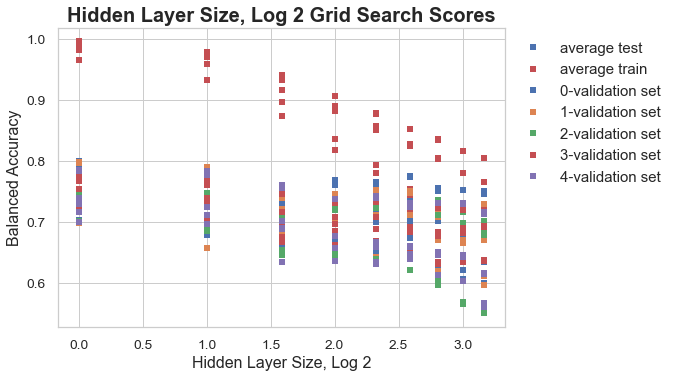

In [107]:
# Plotting the CV results for a gridsearch over one feature

cv_results = tfidf_grid_searcher.cv_results_
# Two plots: One comparing train and test performance; one comparing all of the fold scores against one another 
# Plot one
param = list(tfidf_parameters.keys())[0]
param_label = "Hidden Layer Size, Log 2"

plot_cv_folds(cv_results, param, param_label, folds, log2=True)

# Using pipeline to try many CountVectorizer hyperparameters

In [108]:
count_pipeline = Pipeline([
    ('count', CountVectorizer(stop_words='english')),
#     ('clf', RandomForestClassifier(random_state=RANDOM_STATE)),
    ('clf', sklearn.linear_model.LogisticRegression(penalty='l1', solver='saga', random_state=RANDOM_STATE, C=10.0, max_iter=20))

 ])
count_parameters = {
    'count__min_df': np.arange(1, 10),
    'count__max_df': (0.05, 0.1, 0.5),
    'count__ngram_range': [(1, 1), (1, 2), (2,2)],
}

count_grid_searcher = GridSearchCV(
    count_pipeline, 
    count_parameters, 
    cv=folds, 
    n_jobs=3, 
    verbose=3,
    scoring='balanced_accuracy',
    return_train_score=True
)
count_grid_searcher.fit(x_train_text, y_train)

print("Best parameters set:")
print(count_grid_searcher.best_estimator_.steps)


Fitting 5 folds for each of 81 candidates, totalling 405 fits


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  26 tasks      | elapsed:    9.4s
[Parallel(n_jobs=3)]: Done 122 tasks      | elapsed:   14.1s
[Parallel(n_jobs=3)]: Done 293 tasks      | elapsed:   38.4s
[Parallel(n_jobs=3)]: Done 405 out of 405 | elapsed:   44.0s finished


Best parameters set:
[('count', CountVectorizer(max_df=0.1, stop_words='english')), ('clf', LogisticRegression(C=10.0, max_iter=20, penalty='l1', random_state=123,
                   solver='saga'))]


/Users/dylanphelan/opt/miniconda3/envs/comp135_2020f_env/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


In [109]:
print_gridsearch_results(count_grid_searcher, list(count_parameters.keys()))

Dataframe has shape: (81, 23)
Number of trials used in grid search:  81


,param_count__min_df,param_count__max_df,param_count__ngram_range,mean_train_score,mean_test_score,mean_fit_time,rank_test_score
27,1,0.1,"(1, 1)",0.964167,0.792917,0.691421,1
54,1,0.5,"(1, 1)",0.964167,0.792917,0.664676,1
28,1,0.1,"(1, 2)",0.975833,0.791250,2.136729,3
55,1,0.5,"(1, 2)",0.975833,0.791250,2.137490,3
31,2,0.1,"(1, 2)",0.952708,0.780417,0.411829,5
...,...,...,...,...,...,...,...
74,7,0.5,"(2, 2)",0.522396,0.507500,0.045099,76
20,7,0.05,"(2, 2)",0.522396,0.507500,0.039801,76
26,9,0.05,"(2, 2)",0.514167,0.506250,0.045345,79
53,9,0.1,"(2, 2)",0.514167,0.506250,0.037752,79


In [110]:
best_count_vectorizer = count_grid_searcher.best_estimator_[0]
best_count_vectorizer.fit_transform(x_train_text)
x_train_text_count_best = best_count_vectorizer.transform(x_train_text).toarray()
len(best_count_vectorizer.vocabulary_)

4255

In [111]:
len(x_train_text_count_best[0])

4255

### Archive 

In [58]:
# skf = sklearn.model_selection.StratifiedKFold(n_splits=5)
# count_tf_scores = [[],[]]
# count_tf_train_time = [[],[]]

# for train_index, test_index in skf.split(x_train_text, y_train): 
#     ## Count
#     #
#     count_randforest = RandomForestClassifier(random_state=RANDOM_STATE)
#     # Time the training process
#     start_time_sec = time.time()
#     count_randforest.fit(x_train_text_count[train_index], y_train[train_index])
#     elapsed_time_sec = time.time() - start_time_sec
#     # Get accuracy scores for this split
#     count_y_test_pred = count_randforest.predict(x_train_text_count[test_index])
#     count_balanced_acc = sklearn.metrics.balanced_accuracy_score(
#         y_true=y_train[test_index], 
#         y_pred=count_y_test_pred
#     )
#     print("Performance of the count_vectorized random forest")
#     print(count_balanced_acc)
#     count_tf_scores[0].append(count_balanced_acc)
#     count_tf_train_time[0].append(elapsed_time_sec)
    
#     # TFIDF
#     # 
#     tf_randforest = RandomForestClassifier(random_state=RANDOM_STATE)
#     # Time the training process
#     start_time_sec = time.time()    
#     tf_randforest.fit(x_train_text_tf[train_index], y_train[train_index])
#     elapsed_time_sec = time.time() - start_time_sec
#     # Get accuracy scores for this split
#     tf_y_test_pred=tf_randforest.predict(x_train_text_tf[test_index])
    
#     tf_balanced_acc = sklearn.metrics.balanced_accuracy_score(
#         y_true=y_train[test_index], 
#         y_pred=tf_y_test_pred
#     )
#     print("Performance of the tfidf_vectorized random forest")    
#     print(tf_balanced_acc)
#     count_tf_scores[1].append(tf_balanced_acc)
#     count_tf_train_time[1].append(elapsed_time_sec)
    
# print("Best overall")
# print(f"type:  | score | time ")
# print(f"count: | %5.3f | %4.3f" % (np.mean(count_tf_scores[0]), np.mean(count_tf_train_time[0])))
# print(f"tfidf: | %5.3f | %4.3f" % (np.mean(count_tf_scores[1]), np.mean(count_tf_train_time[1])))
